# ResNet의 구조
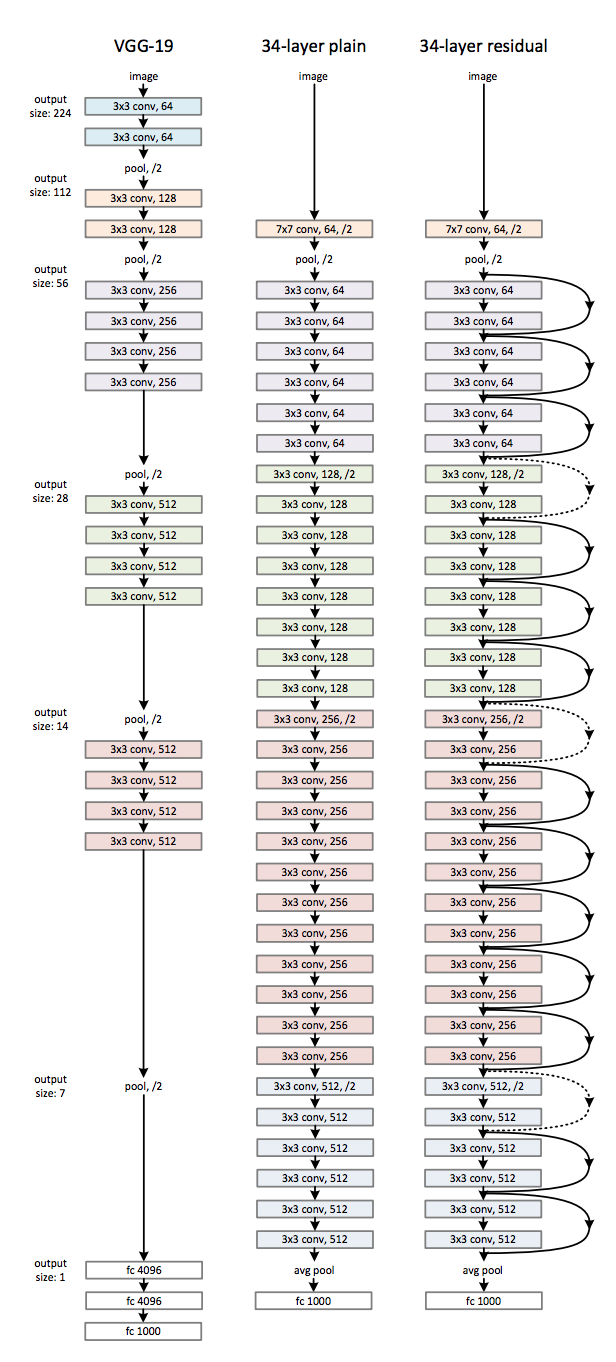

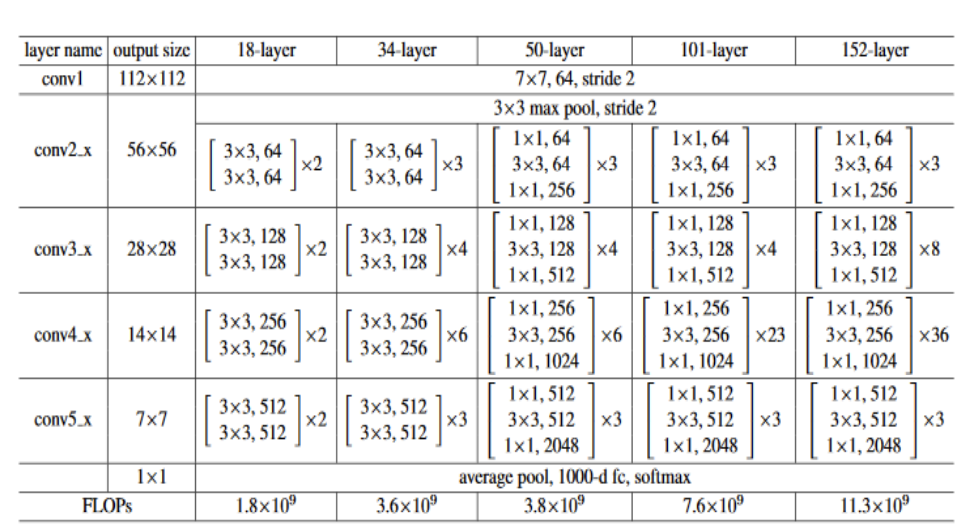

# identity_block 함수 만들기
* `input_x` : block 마다 존재하는 conv에 들어갈 tensor
* `kernel_size` : 커널의 크기. 위 아래 들어가는 커널은 1x1로 고정. 가운데 있는 커널은 3x3 또는 5x5로 언제든 변동 될 수 있도록 할 예정
* `filters` : (1x1), (3x3), (1x1) conv에 들어가는 필터의 각각의 개수
  - 첫 번째 1x1에서는 채널의 숫자를 1/4( 또는 1/2)로 축소
  - 두 번째 3x3에서는 채널의 숫자를 유지
  - 세 번째 1x1에서는 채널의 숫자를 원래대로 복구
* `stage` : identity block들이 여러 개 결합 됐을 때 이를 구분하기 위한 용도. 동일한 필터 수, 동일한 채널을 가지는 identity block 들을 하나의 stage로 설정

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import Add

`Add`는 값을 더해주는 레이어, `Concatenate`는 tensor를 이어주는 레이어

In [ ]:
def identity_block(input_x, middle_kernel_size, filters, stage, block):
  # filter1 : 1x1 필터 개수, filter2 : middle_kernel_size x middle_kernel_size 필터 개수, filter3 : 1x1 필터 개수
  filter1, filter2, filter3 = filters

  # conv, bn에 각각 레이어에 대한 고유한 이름 부여
  # res_2_1_branch -> 2 번 스테이지에 1 번째 Residual
  # bn_2_1_branch -> 2번 스테이지에 1 번째 Bn

  conv_name_base = "res_{}_{}_branch_".format(stage, block)
  bn_name_base   = "bn_{}_{}_branch_".format(stage, block)

  # 첫 번째 연산 - input_x가 들어오고, Conv(1x1) - BN - ReLU
  x = Conv2D(filters=filter1, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+"2a")(input_x)

  # Channel별 Batch Normalization - Bottle Neck 구조이기 때문에, Channel 별로 해야 효과가 있다.
  x = BatchNormalization(axis=3, name=bn_name_base+"2a")(x)
  x = Activation("relu")(x)
  
  # 두 번째 연산 - Conv(3x3) - BN - ReLU
  # Conv 연산이 일어나도 Output Feature Map의 크기가 줄어들면 안되므로 padding='same'으로 설정
  x = Conv2D(filters=filter2,
             kernel_size=middle_kernel_size,
             padding='same',
             kernel_initializer='he_normal',
             name=conv_name_base+"2b")(x)
  x = BatchNormalization(axis=3, name=bn_name_base+"2b")(x)
  x = Activation("relu")(x)

  # 세 번째 연산 - Conv(1x1) - BN. ReLU를 수행하지 않는다. identity mapping을 하고 나서 relu를 수행
  x = Conv2D(filters=filter3,
             kernel_size=(1, 1),
             kernel_initializer='he_normal',
             name=conv_name_base + "2c"
             )(x)
  x = BatchNormalization(axis=3, name=bn_name_base + "2c")(x)

  # identity mapping 구현
  x = Add()([input_x, x]) # x : F(x), input_x : x

  x = Activation("relu")(x) # H(x)
  
  return x

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input = Input(shape=(56, 56, 256), name="test")

filters = [64, 64, 256]
kernel_size = (3, 3)
stage = 2
block = 'a'

output = identity_block(input, kernel_size, filters, stage, block)

identity_layer = Model(inputs=input, outputs=output)
identity_layer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 test (InputLayer)              [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 res_2_a_branch_2a (Conv2D)     (None, 56, 56, 64)   16448       ['test[0][0]']                   
                                                                                                  
 bn_2_a_branch_2a (BatchNormali  (None, 56, 56, 64)  256         ['res_2_a_branch_2a[0][0]']      
 zation)                                                                                          
                                                                                              

# 각 stage 내의 첫 번째 identity block에서 입력 feature map의 크기롤 절반으로 줄이는 block을 생성

* identity block과 굉장히 흡사하지만 입력 feature map의 크기를 절반으로 줄인다. short cut 전달 시 (1x1) stride를 2로 적용
* 단, 첫 번째 stage의 첫 번째 block은 이미 pooling에 의해 절반으로 줄어있는 상태이기 때문에 다시 줄이지 않는다.

In [ ]:
def conv_block(input_x, middle_kernel_size, filters, stage, block, strides=(2, 2)):
  # stirdes = (2, 2)인 이유 : 첫 번째 스테이지 첫 번째 블록에는 (1, 1)만 주기 위해 따로 매개변수로 설정
  filter1, filter2, filter3 = filters
  
  conv_name_base = "res_{}_{}_branch_".format(stage, block)
  bn_name_base   = "bn_{}_{}_branch_".format(stage, block)
  
  # 첫 번째 Conv에서 strides를 적용하여 feature map을 1/2로 줄여준다.
  x = Conv2D(filters=filter1,
             kernel_size=(1, 1),
             strides=strides, # 각 스테이지 별 시작하는 Conv에서 1/2로 줄인다.
             kernel_initializer='he_normal',
             name=conv_name_base+"2a")(input_x)
  
  x = BatchNormalization(axis=3, name=bn_name_base+"2a")(x)
  x = Activation("relu")(x)

  # 두 번째 Conv 연산
  x = Conv2D(filters=filter2,
             kernel_size=middle_kernel_size,
             padding='same',
             kernel_initializer='he_normal',
             name=conv_name_base+"2b")(x)
  x = BatchNormalization(axis=3, name=bn_name_base+"2b")(x)
  x = Activation("relu")(x)

  # 세 번째 Conv 연산
  x = Conv2D(filters=filter3,
             kernel_size=(1, 1),
             kernel_initializer='he_normal',
             name=conv_name_base+"2c")(x)
  x = BatchNormalization(axis=3, name=bn_name_base+"2c")(x)

  # shortcut 만들기(1x1) 연산을 통해서 입력값의 H, W도 1/2로 만들어 주기
  shortcut = Conv2D(filters=filter3, # F(x)의 채널의 수와 맞추기 위함
                    kernel_size=(1, 1),
                    strides=strides, # 원본 데이터의 H, W를 1/2로 만들어 주기 위함
                    kernel_initializer='he_normal',
                    name=conv_name_base+"1")(input_x)
  shortcut = BatchNormalization(axis=3, name=bn_name_base+"1")(shortcut)

  x = Add()([x, shortcut])

  x = Activation("relu")(x)

  return x

* conv_block + identity_block을 이용해서 stage를 구성

In [ ]:
input=Input(shape=(56, 56, 256), name="test")

x = conv_block(input, 3, [64,64,256], stage=2, block='a', strides=(2, 2)) # 입력의 크기가 절반으로 줄어드는 블록
x = identity_block(x, 3, [64,64,256], stage=2, block='b')
output = identity_block(x, 3, [64,64,256], stage=2, block='c')

identity_layer = Model(inputs = input, outputs = output)
identity_layer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 test (InputLayer)              [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 res_2_a_branch_2a (Conv2D)     (None, 28, 28, 64)   16448       ['test[0][0]']                   
                                                                                                  
 bn_2_a_branch_2a (BatchNormali  (None, 28, 28, 64)  256         ['res_2_a_branch_2a[0][0]']      
 zation)                                                                                          
                                                                                            

# Residual Block을 사용하기 전 작업

In [ ]:
from tensorflow.keras.layers import MaxPooling2D
# 단순하게 224, 244, 3 짜리 이미지를 집어 넣고 사용하는 경우

input = Input(shape=(224, 224, 3))

x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(input)
x = BatchNormalization(axis=3)(x)
output = MaxPooling2D((3, 3), strides=(2, 2))(x)

input_layer = Model(inputs=input, outputs=output)
input_layer.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 109, 109, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 64)       0         
 )                                                               
                                                                 
Total params: 9,728
Trainable params: 9,600
Non-trainable params: 128
_________________________________________________________________


O = (I - F + 2P ) / S + 1
  * O : Output Feature Map의 H 또는 W
  * I : 입력되는 H또는 W크기
  * F : 커널의 크기
  * P : 패딩
  * S : 스트라이드

ZeroPadding을 넣지 않고 순수하게 224로 넣었을 때

In [ ]:
((224 - 7 + (2 * 0)) / 2)+1

109.5

ZeroPadding을 위 아래로 3씩 넣어서 230 크기로 넣었을 때

In [ ]:
((230 - 7 + (2 * 0)) / 2)+1

112.5

In [ ]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D

input = Input(shape=(224, 224, 3))

x = ZeroPadding2D(padding=(3, 3))(input)
x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=3)(x)
x = ZeroPadding2D(padding=(1, 1))(x)
output = MaxPooling2D((3, 3), strides=(2, 2))(x)

input_layer = Model(inputs=input, outputs=output)
input_layer.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 230, 230, 3)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 114, 114, 64)     0         
 ng2D)                                                           
                                                           

# ResNet50 완성하기

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

input = Input(shape=(224, 224, 3))

## Feature 입력 부분 ##
x = ZeroPadding2D(padding=(3, 3))(input)
x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=3)(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

## Residual 시작 ##
# Stage 2 - 첫 번째 Residual Block을 구성할 때 strides = (1, 1)로 구성하여 크기를 줄이지 않음
x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

# Stage 3 - 첫 번째 Residual Block을 구성할 때 strides= (2, 2)로 구성하여 크기를 줄인다.
x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

# stage 4의 conv_block과 identity block 생성. stage4의 첫번째 conv_block은 strides를 2(default)로 하여 크기를 줄임
x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

# stage 5의 conv_block과 identity block 생성. stage5의 첫번째 conv_block은 strides를 2(default)로 하여 크기를 줄임
x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

# Fully Connected Layer 구성
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input, outputs=output, name='resnet50')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                          